# UnhapPy Earth - Analyse exploratoire

Étude de cas : Analyse du réchauffement climatique. Analyse exploratoire des données.



## Contexte et objectifs

Notre objectif est de procéder à une analyse préliminaire des différentes jeux de données récupérés sur [le site de Berkeley Earth](http://berkeleyearth.org/data/).

Nous ferons une rapide analyse statistique de chaque jeu de données, visualiserons les valeurs et tendances, et identifierons les valeurs manquantes (NaNs). Dans les cas où cela est possible, nous remplacerons les valeurs manquantes par des valeurs adéquates.

Enfin, nous écrivons les jeux de données nettoyés dans des fichiers CSV afin de pouvoir les utiliser aisément lors de l'analyse suivante.


## Sources et détails des data sets

Afin d’atteindre nos objectifs, nous nous basons sur les Data Sets disponibles sur le site [Berkeley Earth](http://berkeleyearth.org/data/). Cette organisation américaine indépendante se concentre sur la science des données environnementales. Recoupant elle-même plusieurs sources, notamment l'analyse [GISTEMP](https://data.giss.nasa.gov/gistemp/) réalisée sous l'égide de la NASA, elle fournit un ensemble de Data Sets actualisés, complets, avec une large quantité d’information (au total, plus de 19 millions d’observations depuis 46 000 stations météo).

Les Data Sets que nous utilisons pour nos analyses sont les suivants :

*   Températures globales :
  - `Complete_TAVG_complete.txt` : liste des températures globales moyennes sur terres. \
    Format de lecture : fonction `read_txt_file()`

*   Températures par hemisphères :
  - `northern-hemisphere-TAVG-Trend.txt` : liste des températures moyennes par hémisphère (nord) \
    Format de lecture : fonction `read_txt_file()`
  - `southern-hemisphere-TAVG-Trend.txt` : liste des températures moyennes par hémisphère (sud) \
    Format de lecture : fonction `read_txt_file()`

*   Températures par pays :
  - `Sets_by_country` : liste des températures moyennes par pays. \
    Format de lecture : fonction `read_txt_file()`

Chaque jeu de données contient des températures moyennes pour la zone géographique concernée, par mois, avec incertitudes.


## Description des data sets

Il s’agit de fichiers « .txt », chacun d’entre eux correspondant à une région, quel que soit son ordre de grandeur (totalité du globe, hémisphère ou pays). Ils sont tous construits de la même manière.

Chaque fichier contient en en-tête une description, dont un élément crucial : une liste de 12 **températures de référence** absolues mensuelles et leur incertitude sur une période fixe de 30 ans, de janvier 1951 à décembre 1980. Cette période a été retenue d'une part pour la fiabilité et la complétude des observations effectuées, mais surtout car elle représente une sorte de médiane sur l'ensemble du dataset : globalement, la moitié des données seront situées en-dessous de ces valeurs, l'autre moitié au-dessus. Ces références nous permettront de calculer les températures en valeurs absolues.

Ensuite, un tableau donne le détail des résultats moyens sous forme d’anomalies, ou **températures relatives**, assorties de leur incertitude, observés par mois pour la région donnée, pour une période allant de 1750 au plus tôt, et jusqu’en 2021.
Plus d'information concernant ce mesurement et l'intérêt de raisonner en termes d'anomalies peut être trouvé [ici](https://data.giss.nasa.gov/gistemp/faq/abs_temp.html).

* L’anomalie de température est une value relative, exprimée en degrés Celsius correspondant à l’écart, positif ou négatif, entre la température mesurée et la température moyenne de référence correspondante.
* L’incertitude est la dispersion liée à différents facteurs, notamment de sous-échantillonnage statistique et spatial, influant *in fine* sur la qualité de la mesure. Elle représente l'intervalle de confiance à 95 %.

Les données sont réparties sur 12 colonnes :
* Les quatre premières colonnes fournissent les informations suivantes : l’année, le mois de l’année, l’anomalie de température moyenne estimée pour ce mois et son incertitude. 
* Les huit dernières colonnes rapportent les anomalies et incertitudes sous la forme de moyennes glissantes annuelles, quinquennales, décennales et vicennales, centrées sur le mois considéré. Par exemple, la moyenne annuelle de janvier à décembre 1950 est rapportée à juin 1950, ce qui explique la présence de « NaNs » en début et fin de ces colonnes dans les Data Sets.

# Initialisation du NoteBook

Dans cette section nous importons les packages nécessaires et créons les fonctions dont nous nous servirons au cours de l'analyse exploratoire.


## Connexion au Google Drive & Import des packages

In [1]:
# Montage du Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import des packages

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

## Fonction `read_txt_file`

Fonction permettant de lire un fichier de mesures, de récupérer les températures de références et anomalies, puis de calculer les valeurs de températures absolues. 

Calcul des températures absolues: pour calculer la température absolue d’un mois donné, il faut ajouter la valeur d’anomalie correspondant au même mois dans la liste de températures de référence (période 1951 - 1980) citée en en-tête. 

In [3]:
# Définition de la fonction read_text_file

def read_txt_file(file_in: str) -> pd.DataFrame:
    """
    Read a file, extract reference temperatures and anomalies, compute
    absolute temperatures, and return a complete dataframe.
    """
    with open(file_in) as f:
        lines = f.readlines()
    
    temps = pd.DataFrame()
    refs = []
    # Identification des différentes colonnes (Year, Month,  Monthly (Anomaly, Unc.),
    # Annual (Anomaly, Unc.), Five-year (Anomaly, Unc.), Ten-year (Anomaly, Unc.), 
    # Twenty-year (Anomaly, Unc.). La ligne est telle que :
    #   1767     5    -1.595  1.704    -0.483  1.084    -0.792  0.517    -1.062  0.637    -0.931  0.671
    temp_re = re.compile('^\s+(?P<year>\S+)\s+(?P<month>\S+)\s+(?P<ano>\S+)\s+(?P<uncert>\S+)\s+')
    # Identification des différentes colonnes (Jan, Feb, .., Dec) dans une ligne
    # telle que : 
    # 2.60  3.20  5.29  8.28 11.27 13.42 14.30 13.84 12.05  9.21  6.08  3.63
    ref_all_re = re.compile('^%%?\s+((?P<month>[\d.-]+)\s+)+$')
    for line in lines:
        # Check if line is a data line
        m = temp_re.match(line)
        if m:
            record = m.groups()
            record_s = pd.DataFrame(record)
            temps = pd.concat([temps, record_s], axis=1)
            continue
        # Check if line is a reference 
        refs_m = ref_all_re.match(line)
        if refs_m and len(refs) == 0:
            refs = [ float(x) for x in re.findall(r'[\d.-]+', refs_m.group(0)) ]
    
    # Reformat, set column names and types.
    temps = temps.T
    temps.columns = ['year', 'month', 'ano', 'uncert']
    temps['year'] = temps['year'].astype(int)
    temps['month'] = temps['month'].astype(int)
    temps['ano'] = temps['ano'].astype(float)
    temps['uncert'] = temps['uncert'].astype(float)
    
    # Compute absolute temperatures.
    temps['abs'] = temps.agg(lambda x: x['ano'] + refs[int(x['month'])-1], axis=1)
    
    # Prevent floating point black magic by rounding.
    temps.round({'abs': 3})
    
    # Set 'date' column
    temps.insert(0, 'date', pd.to_datetime(temps['year'].map(str) + '-' + temps['month'].map(str) + '-15'))
    
    return temps.reset_index(drop=True)

# Test de la fonction, à décommenter au besoin.
#df = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Complete_TAVG_complete.txt')
#df

## Fonctions de visualisation

Définition de fonctions de plotting, par mois ou par an, pour une ou plusieurs régions. 

### Fonction `plot_month`
Fonction permettant d'afficher un graphique montrant l'évolution des températures par mois, pour un DF donnée, ainsi que leur moyenne glissante sur 12 mois.

In [4]:
# Définition de la fonction plot_month :

def plot_month(df, title) :
  """
  Display both a plot and a scatter plot from a DF, with x = date (by month) and y = absolute temperature.
  Add a cmap to colorize the scatter based on y value.
  Plot 12-months moving average temperature.
  """
  # Set the figure size and grid.
  plt.figure(figsize=(24,10))
  plt.grid(color='grey', alpha=0.2)

  # Display line for monthly measures
  plt.plot(df['date'], df['abs'], c='lightgrey', zorder=1)
  # Display points (circles) for monthly measures
  plt.scatter(df['date'], df['abs'], c=df['abs'], cmap='jet', s=15, zorder=2,
              label='Moyennes mensuelles')
  # Display 12-months moving average as a straight, larger line.
  plt.plot(df['date'], df['mov_average'], color='k', linewidth=2, label='Moyenne glissante sur 12 mois')

  # Add the cmap.
  plt.colorbar()
  plt.clim(df['abs'].min(), df['abs'].max())

  # Labels, legend, title.
  plt.xlabel('Date (par mois)')
  plt.ylabel('Température absolue en °C')
  plt.legend()
  plt.title(title)
  plt.show()

### Fonction `plot_year`
Fonction permettant d'afficher un graphique montrant l'évolution des températures par an, pour un DF donnée, avec ou sans la marge d'incertitude associée.

In [5]:
# Définition de la fonction plot_year :

def plot_year(df, title, show_uncert=False) :
  """
  Display both a plot and a scatter plot from a DF, with x = date (by year) and y = absolute temperature.
  The 'show_uncert' parameter allows, if True, to display the uncertainty margin.
  Add a cmap to colorize the scatter plot based on y value, when uncertainty is not plotted.
  """
  # Compute the average of abs and uncert by year.
  temp_year = df[['year', 'abs', 'uncert']].groupby('year').mean().reset_index()
  # Set the figure size and grid.
  plt.figure(figsize=(24,10))
  plt.grid(color='grey', alpha=0.2)

  # Display absolute temperatures.
  plt.plot(temp_year['year'], temp_year['abs'], c='grey', zorder=1)

  # If required, display points and fill the area of uncertainty measures.  
  if show_uncert==True :
    plt.scatter(temp_year['year'], temp_year['abs'],
              edgecolor='none', zorder=2, label='Moyennes annuelles')
    plt.fill_between(temp_year['year'], 
                 temp_year['abs'] - temp_year['uncert'], 
                 temp_year['abs'] + temp_year['uncert'],
                 color='#D3D3D3', zorder=0, label='Incertitude')
  # Otherwise display absolute temps with a colormap.
  else :
    plt.scatter(temp_year['year'], temp_year['abs'], c=temp_year['abs'],
            cmap='jet', vmin=-40.5, vmax=40, edgecolor='none', zorder=2,
            label='Moyennes annuelles')
    plt.colorbar()
    plt.clim(temp_year['abs'].min(), temp_year['abs'].max())

  # Labels, legend, title.
  plt.xlabel('Date (par annnée)')
  plt.ylabel('Température absolue en °C')
  plt.title(title)
  plt.legend()
  
  plt.show()
  
  # Add some statistics about the graphic.
  print("Ecart maximal de température moyenne annuelle :", round(temp_year['abs'].max() - temp_year['abs'].min(), 3))
  print("Incertitude maximale :", round(temp_year['uncert'].max()*2, 3))
  print("Incertitude minimale :", round(temp_year['uncert'].min()*2, 3))

### Fonction `mult_plot_year`
Fonction permettant d'afficher côte-à-côte deux graphiques montrant l'évolution des températures par mois, pour deux DF (deux régions) donnés.

In [6]:
def mult_plot_year(df_list, label_list, color_list, title) :
  """
  Display multiple plots (with uncertainty margins if available) from a list of DFs,
  with x = date (by year) and y = absolute temperature.
  """
  
  # Set figure size and grid
  plt.figure(figsize=(24,10))
  plt.grid(color='grey', alpha=0.2)
  
  for df, label, color in zip(df_list, label_list, color_list) :
  
    # Compute average absolute temperatures by year
    temp_year = df.groupby('year').mean().reset_index()

    # Display absolute temperatures
    plt.plot(temp_year['year'], temp_year.iloc[:,1], c=color, label=label)
    
    # Display uncertainty if available :
    if len(df.columns) > 2 :
      # Display uncertainty margin
      plt.fill_between(temp_year['year'], 
                       temp_year.iloc[:,1] - temp_year.iloc[:,2], 
                       temp_year.iloc[:,1] + temp_year.iloc[:,2],
                       color=color, alpha = 0.2, label=('Incertitude '+ label))
 
  # Labels, legend, title
  plt.xlabel('Date (par année)')
  plt.ylabel('Température absolue en °C')
  plt.title(title)
  plt.legend()

  plt.show()

# Analyse exploratoire des Data Sets

## Températures globales

### Chargement et description des données

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction `read_txt_file()`, pour les températures globales à la surface des terres.

In [7]:
global_land = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Complete_TAVG_complete.txt')
global_land.head()

,date,year,month,ano,uncert,abs
0,1750-01-15,1750,1,-0.490,3.240,2.110
1,1750-02-15,1750,2,-1.029,3.620,2.171
2,1750-03-15,1750,3,0.211,3.079,5.501
3,1750-04-15,1750,4,-0.166,1.671,8.114
4,1750-05-15,1750,5,-1.589,2.514,9.681


Nous récupérons les informations de colonnes du dataset et leur description statistique :

In [8]:
display(global_land.info())
display(global_land.drop(['year', 'month'], axis=1).describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3265 non-null   datetime64[ns]
 1   year    3265 non-null   int64         
 2   month   3265 non-null   int64         
 3   ano     3264 non-null   float64       
 4   uncert  3262 non-null   float64       
 5   abs     3264 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 153.2 KB


None

,ano,uncert,abs
count,3264.000000,3262.000000,3264.000000
mean,-0.265392,0.902632,8.329213
std,0.961144,1.043254,4.330287
min,-6.018000,0.022000,-2.423000
25%,-0.701250,0.173000,4.290250
50%,-0.197000,0.385000,8.561000
75%,0.244250,1.386250,12.425500
max,5.531000,6.521000,17.780000


Résumé des colonnes :

| Nom   | Type    |NaNs| Description | Exemple | Moyenne | Min | Max |
|-------|---------|----|-------------|---------|---------|-----|-----|
| date  | datetime| 0  | Date au format yyyy-mm-dd. |1950-12-24|X|X|X|
| year  | int     | 0  | L'année au format xxxx. |1950|X|X|X| 
| month | int     | 0  | Le mois au format numérique. |120|X|X|X|
| ano   | float   | 1  | Anomalie constatée (°C). |0.122|-0.265|-6.018|5.531|
| uncert| float   | 3  | Incertitude (°C). |0.041|0.903|0.022|6.521|
| abs   | float   | 1  | Température absolue (°C).|13.124|8.329|-2.423|17.780|


L'anomalie moyenne est relativement proche de 0.

La distribution des températures absolues est régulière, elle dépasse les 20 °C d'amplitude. Ces mesures à la surface des terres uniquement ne sont pas "modérées" par les surfaces océaniques, qui représentent plus de 70% de la surface du globe et sont moins sujettes aux variations de température.

Recherche et identification des données manquantes : 

In [9]:
global_land.isna().sum(axis=0)

date      0
year      0
month     0
ano       1
uncert    3
abs       1
dtype: int64

Lignes du DataSet contenant les NaN :

In [10]:
glo_nan = global_land[global_land.isnull().any(axis=1)]
print (glo_nan)

         date  year  month    ano  uncert     abs
16 1751-05-15  1751      5 -0.890     NaN  10.380
18 1751-07-15  1751      7  1.071     NaN  15.371
32 1752-09-15  1752      9    NaN     NaN     NaN


Méthode de traitement des NaN :

Colonnes       | Nombre de NaN | Traitement NaN
---------------|---|----------------
ano            | 1 |remplacement par interpolation
uncert         | 3 |remplacement par interpolation
abs            | 1 |remplacement par interpolation

Afin de remplacer les NaN, étant donné le faible nombre de NaNs et leur répartition non consécutive, nous considérons que la méthode la plus adéquate pour une étude de températures est l’interpolation linéaire. La fonction `.interpolate()` permet l'estimation d'une ou plusieurs valeurs manquantes situées entre deux valeurs adjacentes connues.

La valeur de la température absolue étant calculée à partir de l'anomalie, il est normal d'avoir autant de NaNs en températures absolues qu'en température relatives. 

In [11]:
global_land = global_land.set_index('date').interpolate()

Nous nous assurons que nous avons bien traité tous les NaN :

In [12]:
global_land = global_land.reset_index()
global_land.isna().sum(axis=0)

date      0
year      0
month     0
ano       0
uncert    0
abs       0
dtype: int64

Nous ressortons les lignes qui contenaient les NaN, pour visualiser que les valeurs manquantes ont été bien traitées, ainsi que les lignes précédentes et suivantes, celles-ci étant la clé pour le calcul par interpolation :

In [13]:
mask = global_land.loc[(global_land['date'] >= '1751-04-15') & (global_land['date'] <= '1751-08-15') | (global_land['date'] >= '1752-08-15') & (global_land['date'] <= '1752-10-15')]
mask

,date,year,month,ano,uncert,abs
15,1751-04-15,1751,4,-1.3240,1.9820,6.9560
16,1751-05-15,1751,5,-0.8900,2.3415,10.3800
17,1751-06-15,1751,6,-1.4220,2.7010,11.9980
18,1751-07-15,1751,7,1.0710,2.1290,15.3710
19,1751-08-15,1751,8,-0.2460,1.5570,13.5940
31,1752-08-15,1752,8,-0.9750,1.3880,12.8650
32,1752-09-15,1752,9,-1.1885,1.5720,10.3365
33,1752-10-15,1752,10,-1.4020,1.7560,7.8080


Moyennes mobiles :

Elles sont essentiellement un outil de suivi de tendance. Pour cet objectif nous créons une colonne 'mov_average' qui indique pour chaque ligne la température moyenne de ce mois et des 11 précédents, grâce à la fonction `.rolling()` de pandas.

Calcul de la moyenne mobile des valeurs absolues :

In [14]:
global_land['mov_average']=global_land['abs'].rolling(12).mean()
global_land.head(15)

,date,year,month,ano,uncert,abs,mov_average
0,1750-01-15,1750,1,-0.490,3.240,2.110,NaN
1,1750-02-15,1750,2,-1.029,3.620,2.171,NaN
2,1750-03-15,1750,3,0.211,3.079,5.501,NaN
3,1750-04-15,1750,4,-0.166,1.671,8.114,NaN
4,1750-05-15,1750,5,-1.589,2.514,9.681,NaN
5,1750-06-15,1750,6,-1.050,1.078,12.370,NaN
6,1750-07-15,1750,7,-0.158,2.715,14.142,NaN
7,1750-08-15,1750,8,0.197,1.623,14.037,NaN
8,1750-09-15,1750,9,-1.084,1.448,10.966,NaN
9,1750-10-15,1750,10,-2.136,2.254,7.074,NaN


### Visualisations

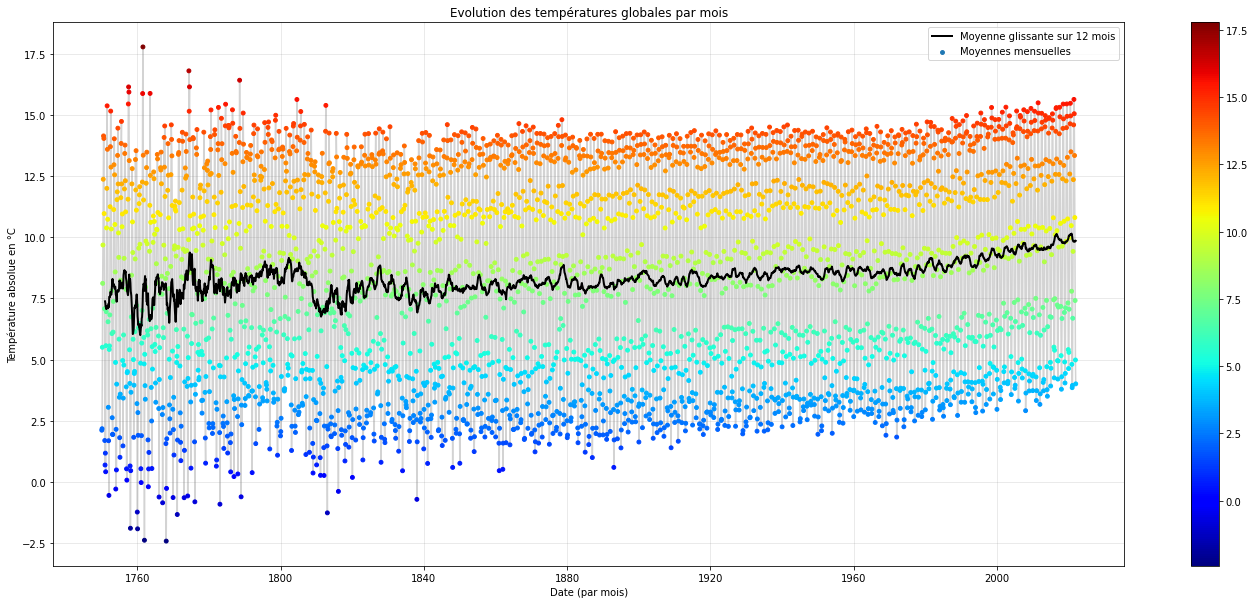

In [15]:
plot_month(global_land, 'Evolution des températures globales par mois')

Les données sont mensuelles, nous pouvons observer des variations saisonales correspondant à chaque année, matérialisées par les bandes de couleurs. Les températures annuelles minimales ont une variance importante comparée aux trois autres saisons.

La moyenne glissante semble confirmer une hausse relativement constante des températures à partir de 1840.

Nous visualisons également les températures moyennes par année, en affichant la marge d'incertitude (pour ce graphique, nous retirons la dernière ligne du tableau - janvier 2022 - afin de travailler sur des années complètes et éviter des valeurs aberrantes) :

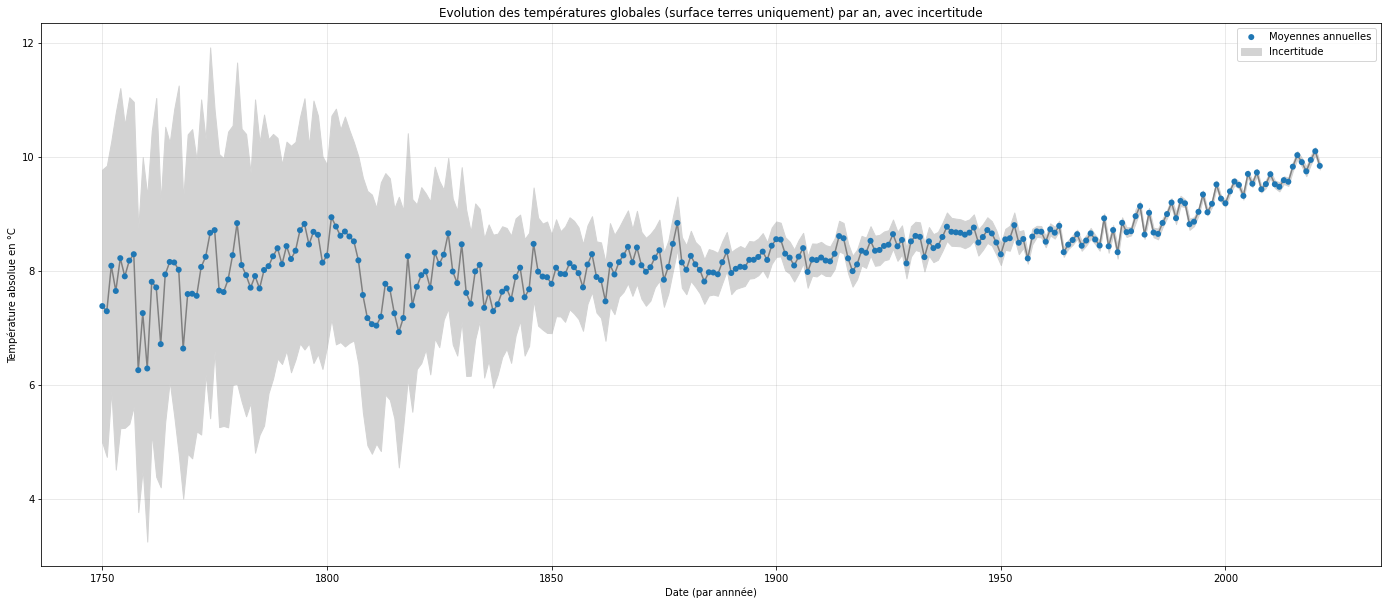

Ecart maximal de température moyenne annuelle : 3.844
Incertitude maximale : 6.65
Incertitude minimale : 0.11


In [16]:
plot_year(global_land[:-1], 
          'Evolution des températures globales (surface terres uniquement) par an, avec incertitude',
          show_uncert=True)

Nous remarquons que la marge d'incertitude s'amincit au cours du temps. Elle est très large jusqu'en 1820 (+ de 6.6 °C d'incertitude !), et très mince à partir de 1960 (0.11 °C de marge dans le meilleur des cas).

L'augmentation du nombre de stations météo, ainsi que le perfectionnement et l'harmonisation des instruments de mesure, ont permis d'obtenir ce niveau de précision.

## Températures par hémisphère

Ces datasets fournissent les températures moyennes à la surface des zones terriennes pour chaque hémisphère. 

### Hemisphère Nord

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction `read_txt_file()`, pour les températures globales sur terres dans l'hémisphère **Nord**. Le jeu de données peut être trouvé sur [le site de BerkeleyEarth](http://berkeleyearth.lbl.gov/regions/northern-hemisphere).

In [17]:
north_hem = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Sets_by_hemisphere/northern-hemisphere-TAVG-Trend.txt')
north_hem.head()

,date,year,month,ano,uncert,abs
0,1840-01-15,1840,1,0.447,1.333,-1.613
1,1840-02-15,1840,2,-0.821,1.100,-0.861
2,1840-03-15,1840,3,-1.050,1.503,3.520
3,1840-04-15,1840,4,-0.455,0.622,9.895
4,1840-05-15,1840,5,-0.002,0.829,15.738


Recherche et identification des données manquantes : 

In [18]:
north_hem.isna().sum(axis=0)

date      0
year      0
month     0
ano       1
uncert    1
abs       1
dtype: int64

Lignes du DataSet contenant les NaN :

In [19]:
north_hem_nan = north_hem[north_hem.isnull().any(axis=1)]
print (north_hem_nan)

         date  year  month  ano  uncert  abs
76 1846-05-15  1846      5  NaN     NaN  NaN


Méthode de traitement des NaN :

Colonnes       | Nombre de NaN | Traitement NaN
---------------|---|----------------
ano            | 1 |remplacement par interpolation
uncert         | 1 |remplacement par interpolation
abs            | 1 |remplacement par interpolation

Nous remarquons la présence de : 1 NaN dans la colonne 'ano', 1 dans 'abs' et 1 dans 'uncert'.

Afin de remplacer les NaN, nous utilisons la fonction .interpolate() tel que dans le data set précédent.

In [20]:
north_hem = north_hem.set_index('date').interpolate()

Nous nous assurons que nous avons bien traité tous les NaN :

In [21]:
north_hem = north_hem.reset_index()
north_hem.isna().sum(axis=0)

date      0
year      0
month     0
ano       0
uncert    0
abs       0
dtype: int64

Nous ressortons les lignes qui contenaient les NaN, pour visualiser que les valeurs manquants ont été bien traités. En plus nous ressortons les lignes qui précèdent et qui succèdent les lignes qui contenaient les NaN, parce que celles-ci sont la clé pour le calcul avec la méthode de l’interpolation :

In [22]:
mask_north_hem = north_hem.loc[(north_hem['date'] >= '1846-04-15') & (north_hem['date'] <= '1846-06-15')]
mask_north_hem

,date,year,month,ano,uncert,abs
75,1846-04-15,1846,4,-0.8650,1.215,9.4850
76,1846-05-15,1846,5,-0.4305,1.093,14.5795
77,1846-06-15,1846,6,0.0040,0.971,19.6740


### Hémisphère Sud

Lecture du jeu de données et affichage des premières lignes, en utilisant la fonction read_txt_file(), pour les températures globales sur terres dans l'hémisphère **Sud**. Le jeu de données peut être trouvé sur [le site de BerkeleyEarth](http://berkeleyearth.lbl.gov/regions/southern-hemisphere).

In [23]:
south_hem = read_txt_file('/content/drive/MyDrive/data/berkeley_earth/Sets_by_hemisphere/southern-hemisphere-TAVG-Trend.txt')
south_hem.head()

,date,year,month,ano,uncert,abs
0,1880-08-15,1880,8,0.323,0.693,13.823
1,1880-09-15,1880,9,-0.712,0.653,14.768
2,1880-10-15,1880,10,-0.688,0.692,16.722
3,1880-11-15,1880,11,-0.206,0.696,19.094
4,1880-12-15,1880,12,-0.357,0.726,20.083


Recherche et identification des données manquantes : 

In [24]:
south_hem.isna().sum(axis=0)

date      0
year      0
month     0
ano       2
uncert    2
abs       2
dtype: int64

Lignes du DataSet contenant les NaN :

In [25]:
south_hem_nan = south_hem[south_hem.isnull().any(axis=1)]
print (south_hem_nan)

         date  year  month  ano  uncert  abs
12 1881-08-15  1881      8  NaN     NaN  NaN
13 1881-09-15  1881      9  NaN     NaN  NaN


Méthode de traitement des NaN :

Colonnes       | Nombre de NaN | Traitement NaN
---------------|---|----------------
ano            | 2 |remplacement par interpolation
uncert         | 2 |remplacement par interpolation
abs            | 2 |remplacement par interpolation

Nous remarquons la présence de : 2 NaN dans la colonne 'ano', 2 dans 'abs' et 2 dans 'uncert'.

Afin de remplacer les NaN, nous utilisons la fonction .interpolate() pareil que dans le data set précèdent.

In [26]:
south_hem = south_hem.set_index('date').interpolate()

Nous nous assurons que nous avons bien traité tous les NaN :

In [27]:
south_hem = south_hem.reset_index()
south_hem.isna().sum(axis=0)

date      0
year      0
month     0
ano       0
uncert    0
abs       0
dtype: int64

Nous ressortons les lignes qui contenaient les NaN, pour visualiser que les valeurs manquants ont été bien traités. En plus nous ressortons les lignes qui précèdent et qui succèdent les lignes qui contenaient les NaN, parce que celles-ci sont la clé pour le calcul avec la méthode de l’interpolation :

In [28]:
mask_south_hem = south_hem.loc[(south_hem['date'] >= '1881-07-15') & (south_hem['date'] <= '1881-10-15')]
mask_south_hem

,date,year,month,ano,uncert,abs
11,1881-07-15,1881,7,-0.598,0.633,11.742
12,1881-08-15,1881,8,-0.468,0.627,13.562
13,1881-09-15,1881,9,-0.338,0.621,15.382
14,1881-10-15,1881,10,-0.208,0.615,17.202



### Aggrégation des données

Nous souhaitons avoir les deux hémisphères réunies dans un seul dataset. Nous les concaténons au format horizontal et nous assurons que les colonnes sont bien nommées.

In [29]:
north_hem_ = north_hem[['date', 'year', 'month', 'ano', 'abs', 'uncert']]
south_hem_ = south_hem[['date', 'ano', 'abs', 'uncert']]
hems = pd.merge(north_hem_, south_hem_, on='date', how='outer')
hems.columns = ['date', 'year', 'month', 'north_ano', 'north_abs', 'north_uncert', 'south_ano', 'south_abs', 'south_uncert']

Description du type des colonnes du jeu de données :

In [30]:
hems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2172 non-null   datetime64[ns]
 1   year          2172 non-null   int64         
 2   month         2172 non-null   int64         
 3   north_ano     2172 non-null   float64       
 4   north_abs     2172 non-null   float64       
 5   north_uncert  2172 non-null   float64       
 6   south_ano     1685 non-null   float64       
 7   south_abs     1685 non-null   float64       
 8   south_uncert  1685 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 169.7 KB


Description statistique des colonnes du jeu de données :

In [31]:
hems.drop(['year', 'month'], axis=1).describe()

,north_ano,north_abs,north_uncert,south_ano,south_abs,south_uncert
count,2172.000000,2172.000000,2172.000000,1685.000000,1685.000000,1685.000000
mean,-0.008925,10.117406,0.281887,0.037392,16.882318,0.286963
std,0.689988,8.328556,0.265848,0.514893,2.953737,0.166241
min,-2.322000,-4.382000,0.042000,-1.380000,11.522000,0.064000
25%,-0.411000,2.671500,0.118000,-0.322000,14.148000,0.131000
50%,-0.049000,10.649000,0.167000,-0.031000,17.076000,0.276000
75%,0.335250,18.284500,0.350250,0.340000,19.656000,0.401000
max,2.883000,22.587000,2.518000,1.709000,22.005000,0.830000


Résumé des colonnes :

| Nom   | Type    |NaNs| Description | Exemple | Moyenne | Min | Max |
|-------|---------|----|-------------|---------|---------|-----|-----|
| date  | datetime| 0  | Date au format yyyy-mm-dd. |1950-12-24|X|X|X|
| year  | int     | 0  | L'année au format xxxx. |1950|X|X|X| 
| month | int     | 0  | Le mois au format numérique. |120|X|X|X|
| north_ano   | float   | 0  | Anomalie constatée (°C). |0.122|-0.0089|-2.322|2.883|
| north_abs| float   | 0  | Température absolue (°C). |0.041|10.117|-4.382|22.587|
| north_uncert   | float   | 0  | Incertitude (°C).|13.124|0.282|0.042|2.518|
| south_ano | float | 487 | Anomalie constatée (°C). |0.122|0.037|-1.38|1.709|
| south_abs | float | 487 | Température absolue (°C). |0.041|16.882|11.522|22.005|
| south_uncert | float   | 487  | Incertitude (°C).|13.124|0.287|0.064|0.83|

L'anomalie moyenne est toujours proche de 0. Grande amplitude pour les températures absolues sur les 2 hémisphères.

Il est à noter que les mesures de températures pour l'hémisphère sud ont commencé bien après les mesures de l'hémisphère nord (respectivement 1880-08-15 et 1840-01-15), d'où un grand nombre de NaNs situés au début du jeu de données pour la partie sud. Etant donné qu'il s'agit de grandes plages de mesures, nous ne pouvons pas les interpoler ou les remplacer sans impacter la pertinence statistique du jeu de données et nous les laisserons tels quels.



Calcul de la moyenne mobile des valeurs absolues :

In [32]:
hems.insert(6, 'mov_avrg_north', hems['north_abs'].rolling(12).mean())
hems.insert(10, 'mov_avrg_south', hems['south_abs'].rolling(12).mean())
hems.head(15)

,date,year,month,north_ano,north_abs,north_uncert,mov_avrg_north,south_ano,south_abs,south_uncert,mov_avrg_south
0,1840-01-15,1840,1,0.447,-1.613,1.333,NaN,NaN,NaN,NaN,NaN
1,1840-02-15,1840,2,-0.821,-0.861,1.100,NaN,NaN,NaN,NaN,NaN
2,1840-03-15,1840,3,-1.050,3.520,1.503,NaN,NaN,NaN,NaN,NaN
3,1840-04-15,1840,4,-0.455,9.895,0.622,NaN,NaN,NaN,NaN,NaN
4,1840-05-15,1840,5,-0.002,15.738,0.829,NaN,NaN,NaN,NaN,NaN
5,1840-06-15,1840,6,-0.079,19.591,0.632,NaN,NaN,NaN,NaN,NaN
6,1840-07-15,1840,7,0.233,21.553,0.668,NaN,NaN,NaN,NaN,NaN
7,1840-08-15,1840,8,-0.721,19.489,0.905,NaN,NaN,NaN,NaN,NaN
8,1840-09-15,1840,9,-1.003,15.627,0.680,NaN,NaN,NaN,NaN,NaN
9,1840-10-15,1840,10,-1.830,9.160,0.730,NaN,NaN,NaN,NaN,NaN


Les data sets de l'hémisphère nord et sud ne commencent pas au même moment (40 ans d'écart : 1840 nord vs. 1880 sud). Pour cette raison les données de l'hémisphère sud et également les données de la moyenne mobile  apparaissent plus tard que les donnes de l'hémisphère nord. 

### Visualisations

Afin de visualiser l'évolution des températures moyennes annuelles dans chaque hémisphère, utilisons la fonction `mult_plot_year` :

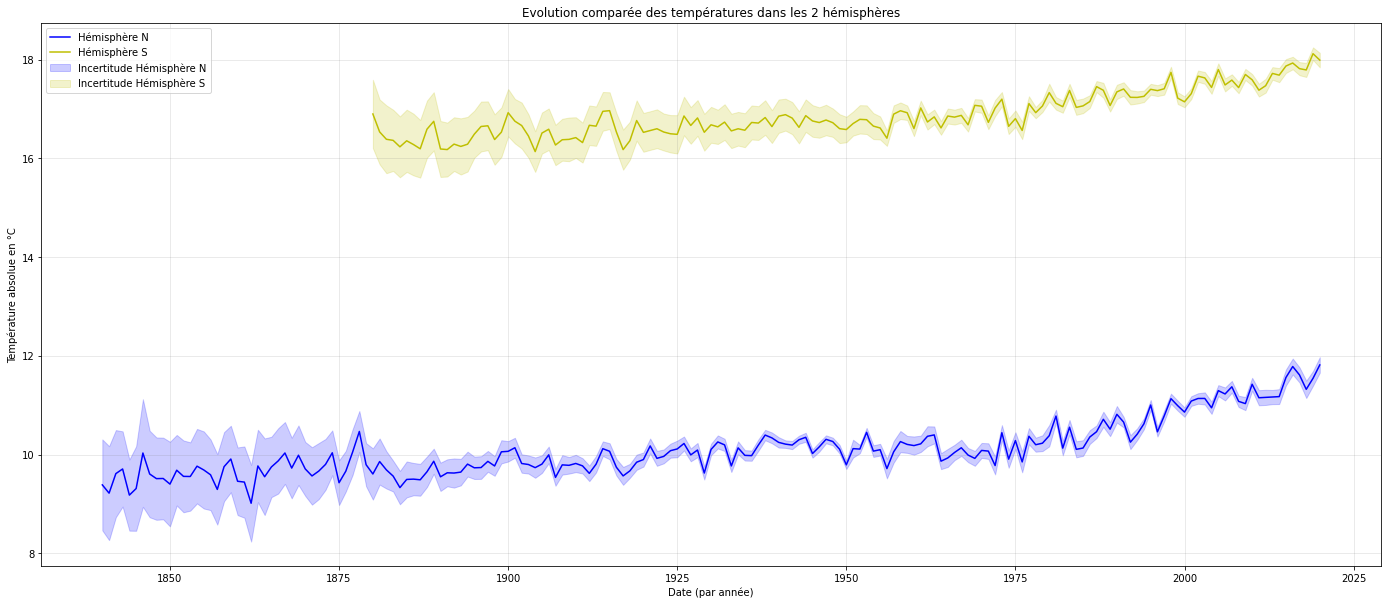

In [33]:
mult_plot_year([hems[['year', 'north_abs', 'north_uncert']], hems[['year', 'south_abs', 'south_uncert']]],
              ['Hémisphère N', 'Hémisphère S'], ['b', 'y'], 'Evolution comparée des températures dans les 2 hémisphères')

Remarquons que :
* La tendance à la hausse est nette dans les 2 hémisphères, dès 1880.
* Les températures mesurées dans l'hémisphère sud maintiennent un écart positif de 6°C env. par rapport à l'hémisphère nord.
La raison de cet écart est un plus grand ensoleillement, la rotation de la terre autour de son axe, ou encore la différence de surface d'eau d'un hémisphère à l'autre (61% au nord / 81% au sud).

## Températures par pays

Chargement du jeu de données et analyse préliminaire :

### Chargement et description des données



In [34]:
# Lecture des données par pays
temps_countries = pd.read_csv('/content/drive/MyDrive/data/berkeley_earth/all_countries_abs.csv')
pd.set_option('display.max_columns', None)
temps_countries

,date,afghanistan,albania,algeria,andorra,angola,anguilla,antarctica,argentina,armenia,aruba,australia,austria,azerbaijan,bahamas,bahrain,bangladesh,barbados,belarus,belgium,belize,benin,bhutan,bolivia,bosnia-and-herzegovina,botswana,brazil,bulgaria,burma,burundi,cabo-verde,cambodia,cameroon,canada,central-african-republic,chad,chile,china,colombia,comoros,congo,costa-rica,croatia,cuba,cyprus,denmark,djibouti,dominica,east-timor,ecuador,egypt,eritrea,estonia,ethiopia,federated-states-of-micronesia,fiji,finland,france,gabon,gambia,georgia,germany,ghana,greece,greenland,grenada,guadeloupe,guam,guatemala,guernsey,guinea,guyana,haiti,honduras,hungary,iceland,india,indonesia,iran,iraq,ireland,islas-baleares,islas-canarias,israel,italy,jamaica,japan,jersey,jordan,kazakhstan,kenya,kiribati,kuwait,kyrgyzstan,laos,latvia,lebanon,lesotho,liberia,libya,liechtenstein,lithuania,luxembourg,macau,macedonia,madagascar,malawi,malaysia,mali,malta,martinique,mauritania,mauritius,mayotte,mexico,moldova,monaco,mongolia,montenegro,montserrat,morocco,mozambique,namibia,nepal,netherlands,new-zealand,nicaragua,niger,nigeria,niue,north-korea,norway,oman,pakistan,palau,palestina,panama,paraguay,peru,philippines,poland,portugal,qatar,reunion,romania,russia,rwanda,samoa,saudi-arabia,senegal,serbia,seychelles,singapore,slovakia,slovenia,solomon-islands,somalia,south-africa,south-korea,spain,sudan,suriname,swaziland,sweden,switzerland,syria,taiwan,tajikistan,tanzania,tasmania,thailand,the-bahamas,timor,togo,tonga,tunisia,turkey,turkmenistan,uganda,ukraine,united-kingdom,united-states-of-america,uruguay,uzbekistan,venezuela,vietnam,yemen,zambia,zimbabwe
0,1743-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1744-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1744-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1744-06-15,NaN,NaN,NaN,NaN,Na

In [35]:
temps_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Columns: 189 entries, date to zimbabwe
dtypes: float64(188), object(1)
memory usage: 4.7+ MB


La colonne 'date' est au format 'object'. Nous souhaitons la convertir au format 'datetime', puis créer une colonne 'year' qui pourra être utile à l'utilisation de certaines fonctions de visualisation.

In [36]:
temps_countries['date'] = pd.to_datetime(temps_countries['date'])
temps_countries.insert(1, 'year', temps_countries['date'].dt.year)
temps_countries

,date,year,afghanistan,albania,algeria,andorra,angola,anguilla,antarctica,argentina,armenia,aruba,australia,austria,azerbaijan,bahamas,bahrain,bangladesh,barbados,belarus,belgium,belize,benin,bhutan,bolivia,bosnia-and-herzegovina,botswana,brazil,bulgaria,burma,burundi,cabo-verde,cambodia,cameroon,canada,central-african-republic,chad,chile,china,colombia,comoros,congo,costa-rica,croatia,cuba,cyprus,denmark,djibouti,dominica,east-timor,ecuador,egypt,eritrea,estonia,ethiopia,federated-states-of-micronesia,fiji,finland,france,gabon,gambia,georgia,germany,ghana,greece,greenland,grenada,guadeloupe,guam,guatemala,guernsey,guinea,guyana,haiti,honduras,hungary,iceland,india,indonesia,iran,iraq,ireland,islas-baleares,islas-canarias,israel,italy,jamaica,japan,jersey,jordan,kazakhstan,kenya,kiribati,kuwait,kyrgyzstan,laos,latvia,lebanon,lesotho,liberia,libya,liechtenstein,lithuania,luxembourg,macau,macedonia,madagascar,malawi,malaysia,mali,malta,martinique,mauritania,mauritius,mayotte,mexico,moldova,monaco,mongolia,montenegro,montserrat,morocco,mozambique,namibia,nepal,netherlands,new-zealand,nicaragua,niger,nigeria,niue,north-korea,norway,oman,pakistan,palau,palestina,panama,paraguay,peru,philippines,poland,portugal,qatar,reunion,romania,russia,rwanda,samoa,saudi-arabia,senegal,serbia,seychelles,singapore,slovakia,slovenia,solomon-islands,somalia,south-africa,south-korea,spain,sudan,suriname,swaziland,sweden,switzerland,syria,taiwan,tajikistan,tanzania,tasmania,thailand,the-bahamas,timor,togo,tonga,tunisia,turkey,turkmenistan,uganda,ukraine,united-kingdom,united-states-of-america,uruguay,uzbekistan,venezuela,vietnam,yemen,zambia,zimbabwe
0,1743-11-15,1743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1744-04-15,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1744-05-15,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1744-06-1

In [37]:
display(temps_countries.describe())

print("Température moyenne mensuelle minimale, observée à l'échelle d'un pays :",
     temps_countries.iloc[:, 2:].min().min())
print("Température moyenne mensuelle maximale, observée à l'échelle d'un pays :",
     temps_countries.iloc[:, 2:].max().max())


,year,afghanistan,albania,algeria,andorra,angola,anguilla,antarctica,argentina,armenia,aruba,australia,austria,azerbaijan,bahamas,bahrain,bangladesh,barbados,belarus,belgium,belize,benin,bhutan,bolivia,bosnia-and-herzegovina,botswana,brazil,bulgaria,burma,burundi,cabo-verde,cambodia,cameroon,canada,central-african-republic,chad,chile,china,colombia,comoros,congo,costa-rica,croatia,cuba,cyprus,denmark,djibouti,dominica,east-timor,ecuador,egypt,eritrea,estonia,ethiopia,federated-states-of-micronesia,fiji,finland,france,gabon,gambia,georgia,germany,ghana,greece,greenland,grenada,guadeloupe,guam,guatemala,guernsey,guinea,guyana,haiti,honduras,hungary,iceland,india,indonesia,iran,iraq,ireland,islas-baleares,islas-canarias,israel,italy,jamaica,japan,jersey,jordan,kazakhstan,kenya,kiribati,kuwait,kyrgyzstan,laos,latvia,lebanon,lesotho,liberia,libya,liechtenstein,lithuania,luxembourg,macau,macedonia,madagascar,malawi,malaysia,mali,malta,martinique,mauritania,mauritius,mayotte,mexico,moldova,monaco,mongolia,montenegro,montserrat,morocco,mozambique,namibia,nepal,netherlands,new-zealand,nicaragua,niger,nigeria,niue,north-korea,norway,oman,pakistan,palau,palestina,panama,paraguay,peru,philippines,poland,portugal,qatar,reunion,romania,russia,rwanda,samoa,saudi-arabia,senegal,serbia,seychelles,singapore,slovakia,slovenia,solomon-islands,somalia,south-africa,south-korea,spain,sudan,suriname,swaziland,sweden,switzerland,syria,taiwan,tajikistan,tanzania,tasmania,thailand,the-bahamas,timor,togo,tonga,tunisia,turkey,turkmenistan,uganda,ukraine,united-kingdom,united-states-of-america,uruguay,uzbekistan,venezuela,vietnam,yemen,zambia,zimbabwe
count,3264.000000,1796.000000,3249.000000,2230.000000,3249.000000,1693.00000,2119.000000,780.00000,1988.000000,2284.000000,2119.000000,1739.000000,3251.000000,2242.000000,2620.000000,1732.000000,2132.000000,2169.000000,3251.000000,3251.000000,2019.000000,1734.000000,2132.000000,1672.000000,3251.000000,1756.000000,1626.000000,3124.000000,2282.000000,1548.000000,1768.000000,2082.000000,1738.000000,2334.000000,1562.000000,1573.000000,1932.000000,2137.000000,1635.000000,1582.000000,1766.000000,1746.000000,3251.000000,2337.000000,2177.000000,2350.000000,1679.000000,2169.000000,1594.000000,1529.000000,1931.000000,1679.000000,3251.000000,1679.000000,1240.000000,1691.000000,3251.000000,3251.000000,1745.000000,1883.000000,2422.000000,3251.000000,1734.000000,2753.000000,2621.000000,2169.000000,2119.000000,1291.000000,1924.000000,3198.000000,1848.000000,2071.000000,2117.000000,1954.000000,3251.000000,2460.000000,2105.000000,1823.000000,1940.000000,2103.000000,3237.000000,3216.000000,1909.000000,2079.000000,3249.000000,2109.000000,2218.000000,3198.000000,2068.000000,2268.000000,1548.000000,1459.000000,1916.000000,1888.000000,2086.000000,3251.000000,2175.000000,1756.000000,1803.000000,1921.000000,3251.000000,3251.000000,3251.000000,2117.000000,3249.000000,1646.000000,1548.000000,1931.000000,1769.000000,2892.000000,2119.000000,1885.000000,1821.000000,1797.000000,2058.000000,3244.000000,3251.000000,2402.000000,3249.000000,2119.000000,2625.000000,1582.000000,1699.000000,2132.000000,3251.000000,2016.000000,1908.000000,1620.000000,1728.000000,1662.000000,2296.000000,3251.000000,1679.000000,1800.000000,1410.000000,1969.000000,1738.000000,1988.000000,1519.000000,1688.000000,3251.000000,2888.000000,1709.000000,1716.000000,3249.000000,2300.000000,1548.000000,1573.000000,1685.000000,1883.000000,3198.000000,1548.000000,1967.000000,3251.000000,3251.000000,1470.000000,1679.000000,1963.000000,2271.000000,3084.000000,1604.000000,1947.000000,1907.000000,3251.000000,3251.000000,2175.000000,2086.000000,1812.000000,1628.000000,1988.000000,2098.000000,2363.000000,1659.000000,1734.000000,1717.000000,2790.000000,2454.000000,2078.000000,1548.000000,3244.000000,3251.000000,2386.000000,1988.000000,2115.000000,2165.000000,2084.000000,1679.000000,1561.000000,1631.000000
mean,1884.480086,14.079393,12.756664,23.243877,11.136555,22.04152,26.618628,-24

Température moyenne mensuelle minimale, observée à l'échelle d'un pays : -40.349
Température moyenne mensuelle maximale, observée à l'échelle d'un pays : 39.384


Il y a 188 pays inclus dans le jeu de données, qui a été récupéré sur [le site de Berkeley](http://berkeleyearth.lbl.gov/country-list/). L'analyse étant plus fine, les valeurs varient beaucoup d'un pays à l'autre, et l'amplitude totale observée est beaucoup plus grande que sur les datasets précédemment analysés : près de 80°C, sur des moyennes nationales mensuelles !

### Analyse des NaNs

Comme le montre l'affichage précédent, il y a un grand nombre de NaNs, en fonction des pays. 

Identification des lignes du dataset contenant les NaN :

In [38]:
df_series_pays= pd.Series(temps_countries.isna().sum(axis=0)) 
df_series_pays.drop(df_series_pays.head(1).index, inplace=True)
nan_pays = pd.DataFrame(df_series_pays)
nan_pays = nan_pays.reset_index(drop=False)
nan_pays.columns =['Pays', 'Num_NaN']
nan_pays.head()

,Pays,Num_NaN
0,year,0
1,afghanistan,1468
2,albania,15
3,algeria,1034
4,andorra,15


Nous remarquons un très grand nombre de NaN. Etant donné le grand nombre de pays, nous allons nous concentrer sur les pays avec le plus, et le moins de NaNs.

Pays avec le MOINS de NaN:

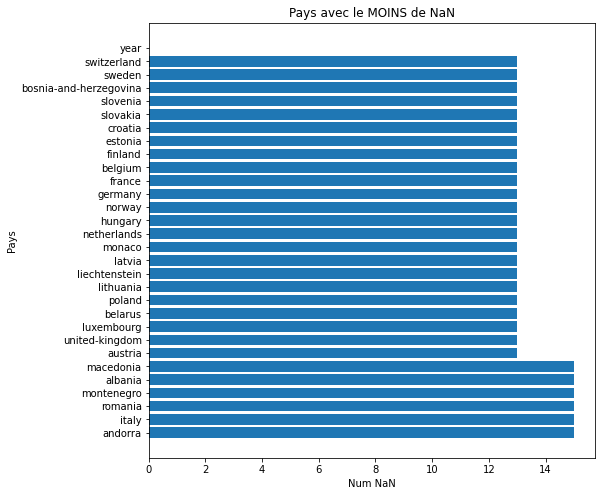

In [39]:
nan_pays_tail = nan_pays.sort_values('Num_NaN', ascending=False)
nan_pays_tail=nan_pays_tail.tail(30)
plt.figure(figsize=(8, 8))

plt.title(label='Pays avec le MOINS de NaN')

plt.barh(nan_pays_tail.Pays, nan_pays_tail.Num_NaN)
plt.xlabel('Num NaN')
plt.ylabel('Pays');

Dans ce graphique nous pouvons remarquer principalement les pays de l'europe. Ce fait s'explique par le fait que la température de l'air n’est généralement disponible qu'à partir d'un nombre limité de stations météorologiques réparties principalement dans les pays les plus développés. 
De plus, cela est lié à la stabilité politique des pays et la présence d'événements politiques ou sociaux qui peuvent empêcher la collecte des donnes, comme par exemple une guerre. 

Nous allons visualiser les valeurs manquantes d'un pays de ce graphique - Germany:

In [40]:
temps_countries_germany = temps_countries[['date', 'germany']]
temps_countries_germany_nan = temps_countries_germany[temps_countries_germany.isnull().any(axis=1)]
print(temps_countries_germany_nan)

         date  germany
0  1743-11-15      NaN
1  1744-04-15      NaN
2  1744-05-15      NaN
3  1744-06-15      NaN
4  1744-07-15      NaN
5  1744-09-15      NaN
6  1744-10-15      NaN
7  1744-11-15      NaN
8  1744-12-15      NaN
9  1745-01-15      NaN
10 1745-02-15      NaN
11 1745-03-15      NaN
12 1745-04-15      NaN


Il s'agit du début du data set et nous comprenons que l'Allemagne a commencé la collecte de ces donnes peu après l'année 1743.

Pays avec le PLUS de NaN:

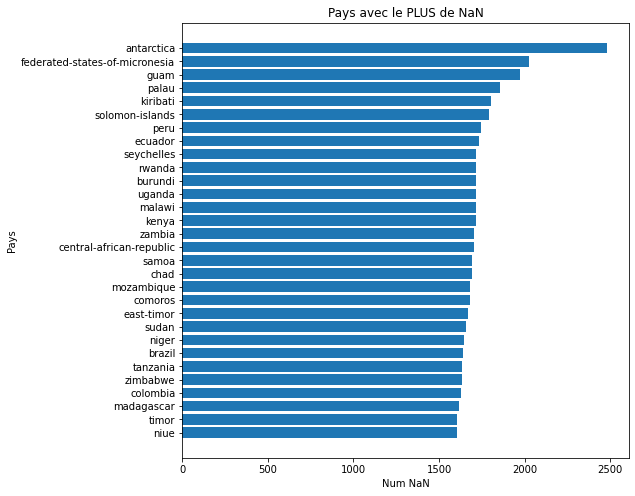

In [41]:
nan_pays_top = nan_pays.sort_values('Num_NaN', ascending=True)
nan_pays_top=nan_pays_top.tail(30)
plt.figure(figsize=(8, 8))
plt.title(label='Pays avec le PLUS de NaN')

plt.barh(nan_pays_top.Pays, nan_pays_top.Num_NaN)
plt.xlabel('Num NaN')
plt.ylabel('Pays');

Dans ce graphique nous pouvons remarquer principalement les pays les moins développés, les pays de hémisphère sud qui ont commencé les études plus tard, soit de très petits pays (e.g. îles) qui n'ont pas comme priorité l'étude de la température, soit des pays avec une situations géopolitique difficile qui entrave la collecte des donnes. 

Conclusion traitement NaN:

Vu le grand nombre de NaN nous décidons de ne pas traiter les valeurs manquantes, car cela impacterait la pertinence statistique du jeu de données. Nous en tiendrons compte lors de notre analyse. 

## CO2

### Chargement et description des données

Les jeux de données sont issus du site de [Our World In Data](https://).

Le [premier dataset](https://github.com/owid/co2-data) contient les données relatives à la génération de CO2 et gaz à effet de serre, depuis 1850 jusqu'à nos jours.

In [42]:
owid_co2_countries = pd.read_csv('/content/drive/MyDrive/data/co2/owid-co2-data.csv')
owid_co2_countries = owid_co2_countries[['year', 'iso_code', 'country', 'co2', 'gdp', 'population', 'total_ghg']]
display(owid_co2_countries.describe())
display(owid_co2_countries.info())

,year,co2,gdp,population,total_ghg
count,25989.000000,24670.000000,1.346900e+04,2.289200e+04,5651.000000
mean,1952.168225,326.658348,2.889570e+11,7.068041e+07,420.520469
std,54.592939,1677.027130,2.185600e+12,3.794737e+08,2955.699936
min,1750.000000,0.000000,5.543200e+07,1.490000e+03,-178.710000
25%,1922.000000,0.557000,9.790110e+09,1.287425e+06,8.030000
50%,1966.000000,5.333000,3.044678e+10,4.869928e+06,33.900000
75%,1994.000000,48.153250,1.274622e+11,1.757624e+07,115.025000
max,2020.000000,36702.503000,1.136302e+14,7.794799e+09,48939.710000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25989 entries, 0 to 25988
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        25989 non-null  int64  
 1   iso_code    21960 non-null  object 
 2   country     25989 non-null  object 
 3   co2         24670 non-null  float64
 4   gdp         13469 non-null  float64
 5   population  22892 non-null  float64
 6   total_ghg   5651 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.4+ MB


None

In [43]:
owid_co2_countries.head()

,year,iso_code,country,co2,gdp,population,total_ghg
0,1949,AFG,Afghanistan,0.015,NaN,7624058.0,NaN
1,1950,AFG,Afghanistan,0.084,9.421400e+09,7752117.0,NaN
2,1951,AFG,Afghanistan,0.092,9.692280e+09,7840151.0,NaN
3,1952,AFG,Afghanistan,0.092,1.001733e+10,7935996.0,NaN
4,1953,AFG,Afghanistan,0.106,1.063052e+10,8039684.0,NaN


Résumé des colonnes :

| Nom   | Type    |NaNs| Description | Exemple | Moyenne | Min | Max |
|-------|---------|----|-------------|---------|---------|-----|-----|
| year  | int     | 0  | L'année au format xxxx. |1950|X|X|X| 
| ico_code   | object   | 4029  | Code ISO du pays. |AFG|X|X|X|
| country| object   | 0  | Dénomination usuelle du pays. |Afghanistan|X|X|X|
| co2   | float   | 1319  | Quantité de $CO^2$ émise (millions de tonnes).|5.333|326.658|0|36702.503|
| gpd | float | 12520 | Produit Intérieur Brut (\$). |3.045e+10|2.89e+11|5.543e+07|1.136e+14|
| population | float | 3097 | Population du pays. |4.87e+06|7.068e+07|1490|7.795e+09|
| total_ghg | float   | 20338  | Quantité totale de gaz à effet de serre émise, en équivalent de $CO^2$ (millions de tonnes).|33.9|420.52|-178.71|48939.71|

Nous souhaitons reformater les données par pays en suivant le même schéma que le jeu de données de la température par pays : les pays en colonnes, et les années en lignes.

In [44]:
df_countries_co2 = owid_co2_countries[['year', 'iso_code', 'co2']]
df_countries_co2 = df_countries_co2.pivot_table(index='year', columns='iso_code', values='co2')

df_countries_population = owid_co2_countries[['year', 'iso_code', 'population']]
df_countries_population = df_countries_population.pivot_table(index='year', columns='iso_code', values='population')

df_countries_total_ghg = owid_co2_countries[['year', 'iso_code', 'total_ghg']]
df_countries_total_ghg = df_countries_total_ghg.pivot_table(index='year', columns='iso_code', values='total_ghg')

In [45]:
df_countries_total_ghg.head()

iso_code,AFG,AGO,ALB,AND,ARE,ARG,ARM,ATG,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BLZ,BOL,BRA,BRB,BRN,BTN,BWA,CAF,CAN,CHE,CHL,CHN,CIV,CMR,COD,COG,COK,COL,COM,CPV,CRI,CUB,CYP,CZE,DEU,DJI,DMA,DNK,DOM,DZA,ECU,EGY,ERI,ESP,EST,ETH,FIN,FJI,FRA,GAB,GBR,GEO,GHA,GIN,GMB,GNB,GNQ,GRC,GRD,GTM,GUY,HND,HRV,HTI,HUN,IDN,IND,IRL,IRN,IRQ,ISL,ISR,ITA,JAM,JOR,JPN,KAZ,KEN,KGZ,KHM,KIR,KNA,KOR,KWT,LAO,LBN,LBR,LBY,LCA,LIE,LKA,LSO,LTU,LUX,LVA,MAR,MDA,MDG,MDV,MEX,MHL,MKD,MLI,MLT,MMR,MNE,MNG,MOZ,MRT,MUS,MWI,MYS,NAM,NER,NGA,NIC,NIU,NLD,NOR,NPL,NRU,NZL,OMN,OWID_WRL,PAK,PAN,PER,PHL,PLW,PNG,POL,PRK,PRT,PRY,QAT,ROU,RUS,RWA,SAU,SDN,SEN,SGP,SLB,SLE,SLV,SOM,SRB,SSD,STP,SUR,SVK,SVN,SWE,SWZ,SYC,SYR,TCD,TGO,THA,TJK,TKM,TLS,TON,TTO,TUN,TUR,TUV,TZA,UGA,UKR,URY,USA,UZB,VCT,VEN,VNM,VUT,WSM,YEM,ZAF,ZMB,ZWE
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990,12.79,65.18,11.51,0.43,69.71,288.37,24.44,0.36,558.21,62.79,75.17,8.33,126.81,20.31,26.04,115.06,76.59,14.06,2.04,33.41,104.36,13.20,104.98,1642.29,3.12,15.51,-5.46,54.94,64.44,626.36,51.19,30.34,2873.71,69.67,71.93,434.87,13.88,0.03,217.08,0.34,-0.27,11.34,43.70,5.35,172.90,1109.28,0.99,0.24,68.51,8.65,95.67,70.40,129.43,4.12,232.63,37.37,94.10,38.27,-0.72,477.92,11.08,746.40,33.78,22.89,21.05,5.16,3.35,4.04,94.44,1.84,28.77,9.59,17.80,27.85,5.13,90.74,1257.10,1009.44,54.11,240.54,78.65,3.38,43.95,456.75,9.39,18.67,1109.37,308.25,34.15,31.63,25.99,0.04,0.19,244.25,32.05,20.45,7.23,17.13,105.32,0.75,0.25,29.15,3.33,45.88,11.56,12.38,34.78,38.12,55.62,0.21,417.45,NaN,13.98,17.91,2.52,207.89,2.24,34.47,84.89,7.12,2.26,19.42,207.11,NaN,19.16,249.87,29.61,0.01,205.44,30.91,20.60,0.13,45.17,14.79,32645.91,166.50,14.11,103.85,98.21,NaN,38.45,429.16,165.49,57.84,75.16,14.08,245.92,2885.12,6.68,190.64,73.23,19.19,31.56,4.31,7.47,8.25,42.49,79.12,36.66,0.10,6.12,57.56,8.35,70.26,2.61,0.22,57.85,24.94,6.89,174.02,17.82,79.18,0.92,0.25,15.23,18.94,189.27,0.02,102.75,34.00,873.70,15.54,5543.47,197.93,0.11,325.64,1.17,0.50,0.47,12.37,319.52,77.42,43.18
1991,12.71,65.85,9.15,0.43,76.25,293.36,25.07,0.37,558.13,66.99,84.19,8.44,131.76,20.44,26.49,115.24,59.37,13.76,2.14,30.87,99.30,13.41,105.78,1669.56,3.15,15.11,-5.41,54.38,65.19,622.29,53.40,29.62,3023.38,75.40,71.62,433.76,16.10,0.03,218.85,0.34,-0.26,11.61,34.84,5.87,156.17,1079.69,1.01,0.24,79.13,9.80,94.54,71.25,135.07,4.66,238.82,33.58,95.87,38.18,-0.70,502.72,11.26,761.64,23.65,23.16,21.37,5.32,3.36,4.09,94.55,1.86,29.24,9.81,17.94,21.34,5.35,85.72,1274.43,1064.49,54.68,280.88,58.30,3.26,45.03,454.34,9.39,19.14,1123.86,318.28,32.92,29.36,25.80,0.04,0.19,269.59,38.74,20.31,8.73,16.85,102.72,0.77,0.25,29.10,3.39,47.61,12.04,10.66,36.19,32.03,55.72,0.21,435.45,0.03,13.31,17.87,2.43,207.34,2.23,36.71,84.87,7.36,2.36,18.71,214.67,19.94,19.68,260.06,28.25,0.01,210.79,28.34,20.99,0.13,44.62,19.16,32813.46,167.45,14.62,102.62,98.27,0.01,39.50,424.94,157.99,59.56,72.17,16.24,203.46,2788.70,6.66,212.83,74.13,19.58,34.74,4.32,7.46,9.10,39.63,68.81,37.56,0.10,6.47,49.51,7.32,70.91,2.65,0.24,62.21,31.37,6.71,186.02,16.95,69.95,0.99,0.27,14.15,19.98,191.74,0.02,103.00,34.55,828.09,17.16,5501.92,200.66,0.11,327.42,4.03,0.51,0.47,14.02,315.46,76.95,43.48
1992,11.25,66.17,7.09,0.43,74.82,297.76,14.95,0.45,560.30,61.20,60.44,8.48,129.84,20.56,26.79,117.14,53.50,15.78,2.80,23.34,85.47,13.63,107.60,1679.50,3.39,15.45,-5.42,54.65,65.67,638.22,53.31,31.95,3154.54,80.99,71.57,434.16,16.01,0.03,222.51,0.34,-0.22,12.71,28.90,6.29,151.72,1032.01,1.02,0.26,72.94,11.31,94.16,73.51,140.18,5.70,248.65,25.79,98.40,35.07,-0.65,487.97,11.46,739.51,15.56,23.88,21.70,5.44,3.40,4.15,96.63,1.92,30.51,9.80,18.27,22.36,5.76,75.77,1295.01,1096.71,54.89,301.84,80.01,3.06,47.82,451.12,10.18,21.89,1137.15,319.10,32.92,21.71,26.45,0.04,0.23,294.15,26.33,20.56,8.78,16.73,99.77,0.88,0.26,30.95,3.61,32.84,11.72,7.97,37.31,26.81,56.05,0.28,438.32,0.11,12.72,17.

Nous nous concentrons sur la quantité de $CO^2$ émise, et visualisons les données pour quelques pays.

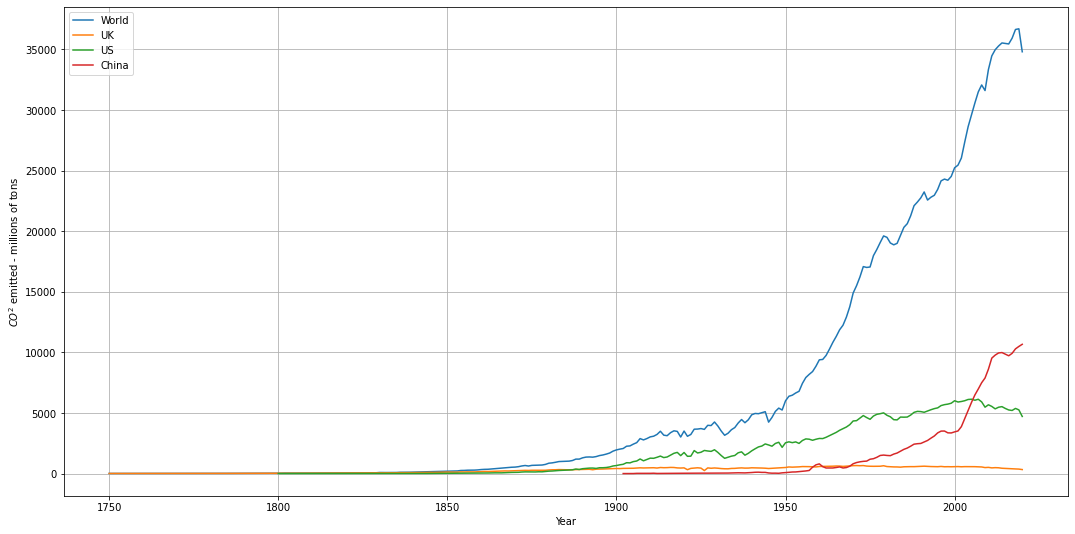

In [46]:
plt.figure(figsize=(18,9))
plt.plot(df_countries_co2.index, df_countries_co2['OWID_WRL'], label='World')
plt.plot(df_countries_co2.index, df_countries_co2['GBR'], label='UK')
plt.plot(df_countries_co2.index, df_countries_co2['USA'], label='US')
plt.plot(df_countries_co2.index, df_countries_co2['CHN'], label='China')
plt.ylabel('$CO^2$ emitted - millions of tons')
plt.xlabel('Year')
plt.grid()
plt.legend()
plt.show()

Recherche et analyse des valeurs manquantes :

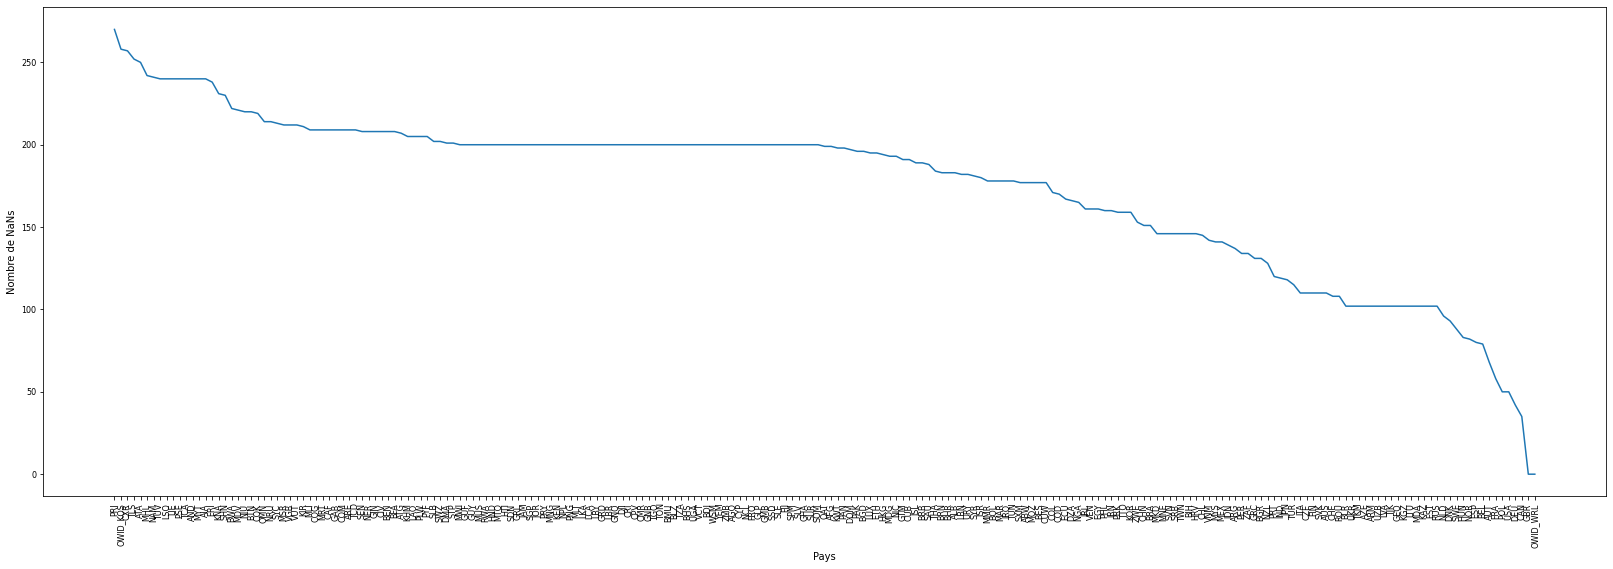

In [47]:
tmp = df_countries_co2.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(28,9))
plt.plot(tmp.index, tmp)
plt.xlabel('Pays')
plt.ylabel('Nombre de NaNs')
plt.xticks(rotation = 90)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
plt.show()

Comme pour le dataset précédent des températures par pays, les valeurs manquantes sont liées à des périodes où le pays, pour quelque raison que ce soit, n'a pas pu collecter les données. Nous les laisserons tels quels pour ne pas compromettre l'intégrité statistique des données. 


Le [deuxième dataset](https://ourworldindata.org/grapher/global-co2-fossil-plus-land-use?time=1851..2020&country=~OWID_WRL) contient les données annuelles d'émissions de $CO^2$ venant des énergies fossiles et industrielles, plus celles liées à l'utilisation de la terre. 

In [48]:
owid_co2_global = pd.read_csv('/content/drive/MyDrive/data/co2/global-co2-fossil-plus-land-use.csv')
owid_co2_global = owid_co2_global[['Year', 'Land use emissions (GtCO2)', 'Fossil fuel and industry emissions (GtCO2)']]
display(owid_co2_global.describe())
display(owid_co2_global.info())

,Year,Land use emissions (GtCO2),Fossil fuel and industry emissions (GtCO2)
count,171.000000,1.710000e+02,1.710000e+02
mean,1935.000000,4.323198e+09,9.894513e+09
std,49.507575,1.031495e+09,1.100103e+10
min,1850.000000,2.498654e+09,1.968960e+08
25%,1892.500000,3.671737e+09,1.364487e+09
50%,1935.000000,4.390409e+09,4.170574e+09
75%,1977.500000,4.903686e+09,1.868515e+10
max,2020.000000,6.990010e+09,3.670250e+10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 3 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Year                                        171 non-null    int64  
 1   Land use emissions (GtCO2)                  171 non-null    float64
 2   Fossil fuel and industry emissions (GtCO2)  171 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.1 KB


None

Résumé des colonnes :

| Nom   | Type    |NaNs| Description | Exemple | Moyenne | Min | Max |
|-------|---------|----|-------------|---------|---------|-----|-----|
| Year  | int     | 0  | L'année au format xxxx. |1950|X|X|X| 
| Land use emissions (GtCO2)   | float   | 0  | Quantité de $CO^2$ émise par l'utilisation des terres (millions de tonnes).|4.39e+09|2.499e+09|0|6.99e+09|
| Fossil fuel and industry emissions (GtCO2) | float | 0 | Quantité de $CO^2$ émise par l'industrie et la production d'énergie (millions de tonnes). |4.17e+09|9.894e+09|1.969e+08|3.67e+10|

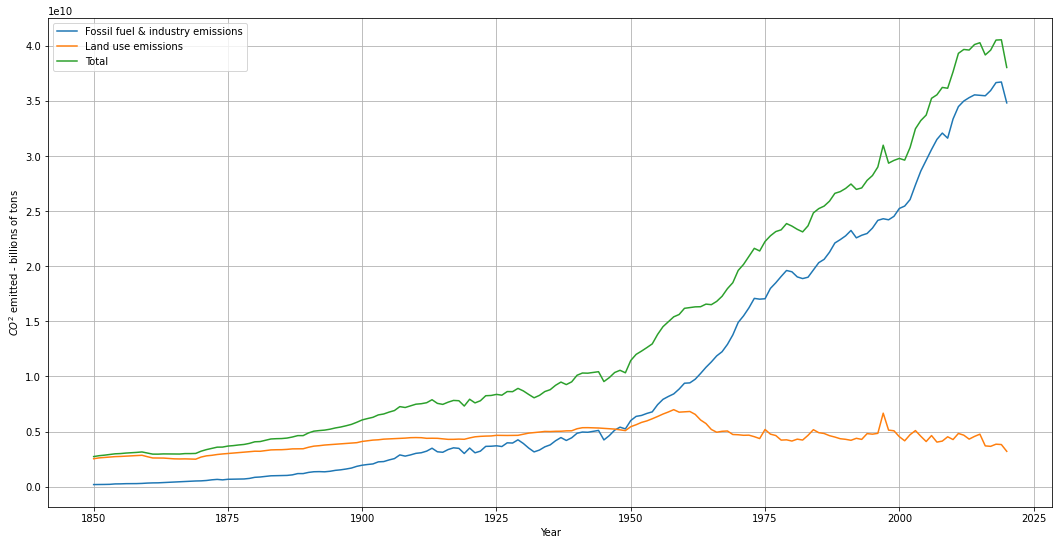

In [49]:
plt.figure(figsize=(18,9))
plt.plot(owid_co2_global['Year'], owid_co2_global['Fossil fuel and industry emissions (GtCO2)'], label='Fossil fuel & industry emissions')
plt.plot(owid_co2_global['Year'], owid_co2_global['Land use emissions (GtCO2)'], label='Land use emissions')
plt.plot(owid_co2_global['Year'], owid_co2_global['Land use emissions (GtCO2)'] + owid_co2_global['Fossil fuel and industry emissions (GtCO2)'], label='Total')
plt.ylabel('$CO^2$ emitted - billions of tons')
plt.xlabel('Year')
plt.grid()
plt.legend()
plt.show()

Ce jeu de données ne contient aucune valeur manquante.

# Ecriture des Data Sets

Nous écrivons les jeux de données nettoyés sur disque, au format CSV. 
* `temperatures_globales.csv`
* `temperatures_hemispheres.csv`
* `temperatures_countries.csv`
* `co2_global.csv`
* `co2_countries.csv`

In [50]:
global_land.to_csv('/content/drive/MyDrive/data/unhappy_earth/temperatures_globales.csv', index=False)
hems.to_csv('/content/drive/MyDrive/data/unhappy_earth/temperatures_hemispheres.csv', index=False)
temps_countries.to_csv('/content/drive/MyDrive/data/unhappy_earth/temperatures_countries.csv', index=False)
owid_co2_global.to_csv('/content/drive/MyDrive/data/unhappy_earth/co2_global.csv', index=False)
df_countries_co2.to_csv('/content/drive/MyDrive/data/unhappy_earth/co2_countries.csv', index=True)